In [17]:
## 必要なライブラリのインポート
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import time
import sys

## データの読み込み（パスを `/work/` に変更）
items = pd.read_csv('/work/items.csv')
shops = pd.read_csv('/work/shops.csv')
cats = pd.read_csv('/work/item_categories.csv')
train = pd.read_csv('/work/sales_train.csv')

# set index to ID to avoid dropping it later
test = pd.read_csv('/work/test.csv').set_index('ID')

## 外れ値処理
# 外れ値の除外
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]

# 価格が負のアイテムの処理
median = train[(train.shop_id == 32) & (train.item_id == 2973) & (train.date_block_num == 4) & (train.item_price > 0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

## データの前処理

# ショップIDの重複修正
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# ショップ名、カテゴリ名からの情報抽出とエンコード
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## 月間売上データの作成
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):  # **in** のエラーを修正
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)

train['revenue'] = train['item_price'] * train['item_cnt_day']

group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16)

## テストセットの作成
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False)
matrix.fillna(0, inplace=True)

## 特徴量生成
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')

## データセットの分割
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)


In [35]:
model = XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    min_child_weight=200,
    colsample_bytree=0.8,
    subsample=0.6,
    eval_metric="rmse",
    early_stopping_rounds=10,
    random_state=42
)

model.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
)

[0]	validation_0-rmse:1.22065	validation_1-rmse:1.13388
[1]	validation_0-rmse:1.21719	validation_1-rmse:1.13027
[2]	validation_0-rmse:1.21384	validation_1-rmse:1.12735
[3]	validation_0-rmse:1.21119	validation_1-rmse:1.12524
[4]	validation_0-rmse:1.20800	validation_1-rmse:1.12225
[5]	validation_0-rmse:1.20541	validation_1-rmse:1.11961
[6]	validation_0-rmse:1.20295	validation_1-rmse:1.11730
[7]	validation_0-rmse:1.19949	validation_1-rmse:1.11413
[8]	validation_0-rmse:1.19703	validation_1-rmse:1.11227
[9]	validation_0-rmse:1.19462	validation_1-rmse:1.11025
[10]	validation_0-rmse:1.19217	validation_1-rmse:1.10804
[11]	validation_0-rmse:1.18976	validation_1-rmse:1.10549
[12]	validation_0-rmse:1.18743	validation_1-rmse:1.10347
[13]	validation_0-rmse:1.18495	validation_1-rmse:1.10115
[14]	validation_0-rmse:1.18313	validation_1-rmse:1.09970
[15]	validation_0-rmse:1.18155	validation_1-rmse:1.09823
[16]	validation_0-rmse:1.18004	validation_1-rmse:1.09725
[17]	validation_0-rmse:1.17817	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=200, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
Y_pred = model.predict(X_valid).clip(0, 20) 
rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred))
print(f'Validation RMSE: {rmse}')


Validation RMSE: 0.9283482498212441


In [24]:
Y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({
'ID': test.index,
'item_cnt_month': Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [ ]:
def categorize_sales(x):
    if x == 0:
        return 'no_sales'
    elif x <= 5:
        return 'low'
    elif x <= 15:
        return 'medium'
    else:
        return 'high'

Y_train = Y_train.apply(categorize_sales)
Y_valid = Y_valid.apply(categorize_sales)


In [32]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# カテゴリ変数を数値に変換
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_valid_encoded = label_encoder.transform(Y_valid)
# XGBClassifier の設定（eval_metric 追加）
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    eval_metric="mlogloss",# 追加！
    n_jobs=-1 
)

# モデルの学習（verbose=True 追加）
model.fit(X_train, Y_train_encoded, eval_set=[(X_train, Y_train_encoded), (X_valid, Y_valid_encoded)], verbose=True)


[0]	validation_0-mlogloss:1.34323	validation_1-mlogloss:1.34218
[1]	validation_0-mlogloss:1.30334	validation_1-mlogloss:1.30143
[2]	validation_0-mlogloss:1.26555	validation_1-mlogloss:1.26258
[3]	validation_0-mlogloss:1.23001	validation_1-mlogloss:1.22631
[4]	validation_0-mlogloss:1.19592	validation_1-mlogloss:1.19159
[5]	validation_0-mlogloss:1.16356	validation_1-mlogloss:1.15842
[6]	validation_0-mlogloss:1.13282	validation_1-mlogloss:1.12710
[7]	validation_0-mlogloss:1.10371	validation_1-mlogloss:1.09736
[8]	validation_0-mlogloss:1.07597	validation_1-mlogloss:1.06903
[9]	validation_0-mlogloss:1.04948	validation_1-mlogloss:1.04204
[10]	validation_0-mlogloss:1.02422	validation_1-mlogloss:1.01633
[11]	validation_0-mlogloss:1.00015	validation_1-mlogloss:0.99176
[12]	validation_0-mlogloss:0.97721	validation_1-mlogloss:0.96838
[13]	validation_0-mlogloss:0.95520	validation_1-mlogloss:0.94577
[14]	validation_0-mlogloss:0.93448	validation_1-mlogloss:0.92460
[15]	validation_0-mlogloss:0.91435	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# 予測
Y_pred_encoded = model.predict(X_valid)

# 数値のラベルをカテゴリに戻す
Y_pred = label_encoder.inverse_transform(Y_pred_encoded)

# 評価
print(classification_report(Y_valid, Y_pred))
print(confusion_matrix(Y_valid, Y_pred))


              precision    recall  f1-score   support

        high       0.62      0.23      0.33       358
         low       0.63      0.21      0.31     29869
      medium       0.51      0.13      0.21      1244
    no_sales       0.89      0.98      0.94    206701

    accuracy                           0.88    238172
   macro avg       0.66      0.39      0.45    238172
weighted avg       0.86      0.88      0.85    238172

[[    81     29     35    213]
 [    14   6221    101  23533]
 [    34    528    163    519]
 [     1   3142     22 203536]]


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# lag特徴量の列を削除（Nanが多いため）
X_train = X_train.drop(columns=['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
                                'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 
                                'item_cnt_month_lag_12'])
X_valid = X_valid.drop(columns=['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
                                'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 
                                'item_cnt_month_lag_12'])
X_test = X_test.drop(columns=['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
                              'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 
                              'item_cnt_month_lag_12'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [20]:
# PCAの適用
pca = PCA(n_components=0.95)  # 寄与率の合計が95%になるまでの主成分を抽出
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [21]:
print("PCA適用前の次元数:", X_train.shape[1])
print("PCA適用後の次元数:", X_train_pca.shape[1])


PCA適用前の次元数: 7
PCA適用後の次元数: 5


In [24]:
for variance in [0.70, 0.80, 0.99]:
    pca = PCA(n_components=variance)
    X_train_pca = pca.fit_transform(X_train_scaled)
    print(f"寄与率 {variance*100}% のときの次元数: {X_train_pca.shape[1]}")


寄与率 70.0% のときの次元数: 3
寄与率 80.0% のときの次元数: 4
寄与率 99.0% のときの次元数: 5


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## データ作成
# items と cats を結合
items_extended = pd.merge(items, cats, on='item_category_id', how='left')

# 商品ごとの平均価格を計算
average_price = train.groupby('item_id')['item_price'].mean().reset_index()
average_price.columns = ['item_id', 'average_price']

# 商品情報と価格情報を結合
items_extended = pd.merge(items_extended, average_price, on='item_id', how='left')

## 特徴量のスケーリング
features = items_extended[['average_price']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Nanのある行を削除
features_scaled = features_scaled[~np.isnan(features_scaled).any(axis=1)]
items_extended = items_extended[~features.isna().any(axis=1)]

In [28]:
# K-means クラスタリング
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

In [29]:
silhouette_avg = silhouette_score(features_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# クラスタリング結果の追加
items_extended['cluster'] = clusters

# クラスタ毎のデータ分析
print(items_extended.groupby('cluster').mean())

Silhouette Score: 0.7342297756261653
              item_id  item_category_id  type_code  subtype_code  \
cluster                                                            
0        11375.309192         45.681871  11.340503     19.011648   
1         9741.953488         41.116279   8.976744     22.023256   
2         8235.102616         49.064386  10.488934     27.981891   
3        10008.130178         35.893491   8.088757     21.952663   
4        10266.187217         49.233555  10.882024     28.290812   

         average_price  
cluster                 
0           329.060992  
1         29131.013082  
2          4705.262898  
3         11556.375183  
4          1706.484440  


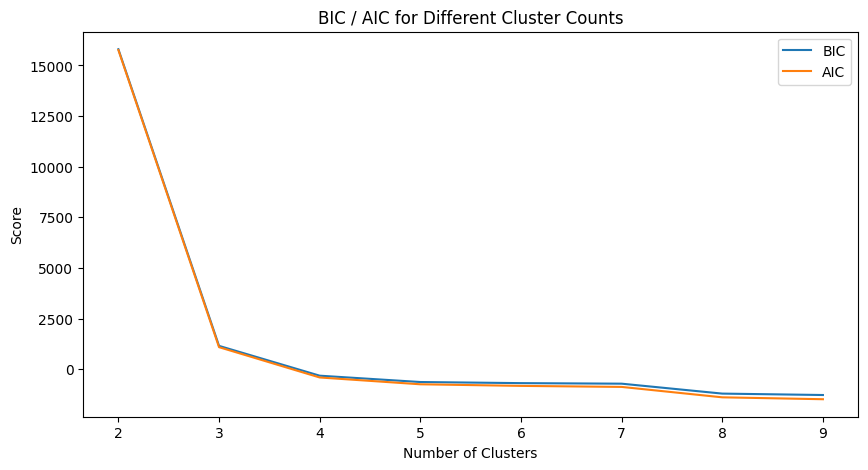

In [32]:
from sklearn.mixture import GaussianMixture

# クラスタ数を決めるために BIC / AIC を計算
bic_scores = []
aic_scores = []
n_clusters_range = range(2, 10)  # 2~9 クラスタで試す

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(features_scaled)
    
    bic_scores.append(gmm.bic(features_scaled))
    aic_scores.append(gmm.aic(features_scaled))

# BIC / AIC の値をプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, bic_scores, label='BIC')
plt.plot(n_clusters_range, aic_scores, label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('BIC / AIC for Different Cluster Counts')
plt.show()


In [33]:
# BIC が最小になるクラスタ数を設定
optimal_clusters = 4 

# GMM クラスタリングを実行
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
clusters_gmm = gmm.fit_predict(features_scaled)

# クラスタリング結果をデータに追加
items_extended['gmm_cluster'] = clusters_gmm

# クラスタごとの統計情報を表示
print(items_extended.groupby('gmm_cluster').mean())


                  item_id  item_category_id  type_code  subtype_code  \
gmm_cluster                                                            
0            11524.714265         45.395120  11.430092     17.279279   
1             9444.971530         40.167260   8.861210     23.526690   
2            10634.846372         48.683929  11.066425     27.519597   
3             8690.377674         45.390698   9.832558     27.411163   

             average_price   cluster  
gmm_cluster                           
0               231.967881  0.000000  
1             13175.495792  2.448399  
2              1121.662235  1.956871  
3              3311.921592  3.203721  


In [34]:
from sklearn.metrics import silhouette_score

silhouette_avg_gmm = silhouette_score(features_scaled, clusters_gmm)
print(f'GMM Silhouette Score: {silhouette_avg_gmm}')



GMM Silhouette Score: 0.6545495036326153
